In [121]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from astromodule.io import read_table
import pandas as pd
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, roc_curve
import tensorflow as tf

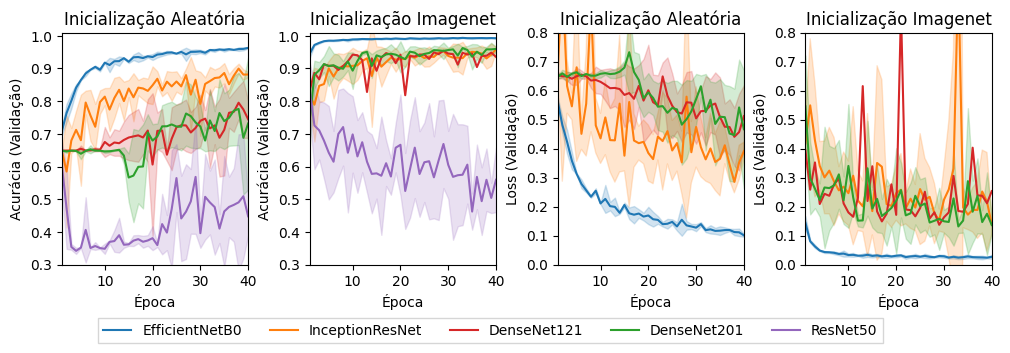

In [107]:
def plot_metric(
  table: str, 
  metric: str, 
  ylabel: str, 
  ylim: tuple = None, 
  ignore = [],
  title=None,
  ax = None,
):
  df_base_acc = read_table(table).iloc[:40]
  df_base_acc['Step'] += 1
  prefix = ['efb0', 'inception', 'dn121', 'dn201', 'rn50']
  name = ['EfficientNetB0', 'InceptionResNet', 'DenseNet121', 'DenseNet201', 'ResNet50']
  colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green', 'tab:purple']
  if not ax:
    fig, ax = plt.subplots(figsize=(8, 4))
  for p, n, c in zip(prefix, name, colors):
    if p not in ignore:
      df = df_base_acc.filter(regex=f'{p}.*{metric}$')
      mean = df.mean(axis=1)
      std = df.std(axis=1)
      x = np.arange(len(df)) + 1
      ax.plot(x, mean, color=c, label=n)
      ax.fill_between(x, mean-std, mean+std, color=c, alpha=0.2)
  ax.set_xlim(x.min(), x.max())
  if ylim:
    ax.set_ylim(ylim)
  ax.set_ylabel(ylabel)
  ax.set_xlabel('Época')
  box = ax.get_position()
  ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
  if title:
    ax.set_title(title)
  
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
plot_metric('baseline_acc.csv', 'ACC', 'Acurácia (Validação)', (0.3, 1.01), [], 'Inicialização Aleatória', axs[0])
plot_metric('imagenet_acc.csv', 'ACC', 'Acurácia (Validação)', (0.3, 1.01), [], 'Inicialização Imagenet', axs[1])
plot_metric('baseline_loss.csv', 'loss', 'Loss (Validação)', (0.0, 0.8), ['rn50'], 'Inicialização Aleatória', axs[2])
plot_metric('imagenet_loss.csv', 'loss', 'Loss (Validação)', (0.0, 0.8), ['rn50'], 'Inicialização Imagenet', axs[3])

fig.subplots_adjust(bottom=0.3, wspace=0.33)
axs[0].legend(loc='upper center', bbox_to_anchor=(2.3, -0.2),fancybox=False, shadow=False, ncol=5)
plt.savefig('figures/model_arch.pdf', bbox_inches='tight', pad_inches=0.05)

0.010154850151447828 0.0068290462098793536 0.9924843423799582
0.04123723703188875 0.028226724334167994 0.969937369519833


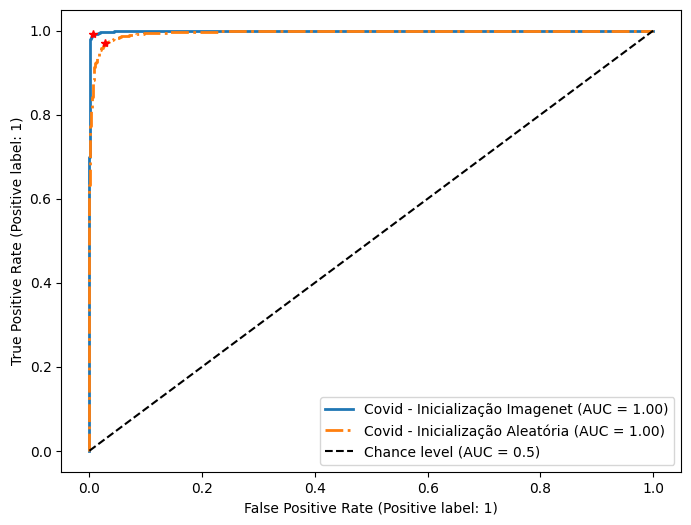

In [130]:
def plot_roc(table, color='tab:blue', label='', diagonal=True, linestyle='-', ax=None):
  df = read_table(table)
  y_true = np.load('y_test.npy')
  display = RocCurveDisplay.from_predictions(
    y_true,
    df.prob_covid.values,
    name=label,
    color=color,
    linestyle=linestyle,
    lw=2,
    plot_chance_level=diagonal,
    ax=ax,
  )
  fpr, tpr, thresholds = roc_curve(y_true, df.prob_covid.values)
  fnr = 1 - tpr
  dist = np.sqrt(np.power(fpr, 2) + np.power(tpr - 1, 2))
  idx = np.argmin(dist)
  display.ax_.plot([fpr[idx]], [tpr[idx]], 'r*')
  print(dist[idx], fpr[idx], tpr[idx])
  return display

fig, axs = plt.subplots(figsize=(8, 6))
plot_roc('imagenet_best_test.csv', color='tab:blue', label='Covid - Inicialização Imagenet', diagonal=False, ax=axs)
plot_roc('baseline+classweight_best_test.csv', color='tab:orange', label='Covid - Inicialização Aleatória', linestyle='-.', ax=axs)
plt.savefig('figures/best_models_roc.pdf', bbox_inches='tight', pad_inches=0.05)

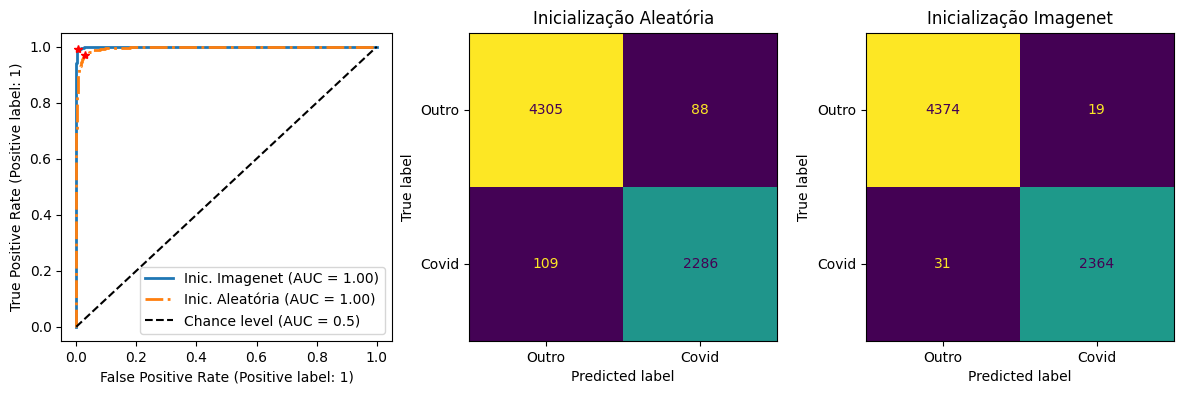

In [127]:
def plot_conf_matrix(table, title=None, colorbar=True, ylabel=True, ax=None):
  disp = ConfusionMatrixDisplay.from_predictions(
    np.load('y_test.npy'), 
    (read_table(table).prob_covid.values > 0.5).astype('uint8'),
    display_labels=['Outro', 'Covid'],
    colorbar=colorbar,
    ax=ax,
  )
  
  if not ylabel:
    disp.ax_.set_ylabel(None)
  
  if title:
    disp.ax_.set(title=title)
  return disp.ax_

fig, axs = plt.subplots(1, 3, figsize=(14.5, 4))
plot_roc('imagenet_best_test.csv', color='tab:blue', label='Inic. Imagenet', diagonal=False, ax=axs[0])
plot_roc('baseline+classweight_best_test.csv', color='tab:orange', label='Inic. Aleatória', linestyle='-.', ax=axs[0])
plot_conf_matrix('baseline+classweight_best_test.csv', 'Inicialização Aleatória', False, True, axs[1])
plot_conf_matrix('imagenet_best_test.csv', 'Inicialização Imagenet', False, True, axs[2])
plt.savefig('figures/best_models_cm.pdf', bbox_inches='tight', pad_inches=0.05)